In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
number = LabelEncoder()
from statsmodels.stats.outliers_influence import summary_table

# Adjust css for usability
from IPython.core.display import HTML
HTML('''
<style type="text/css">

.jp-RenderedHTMLCommon table {
    table-layout: auto;
    border-collapse: collapse;
    width: 75%;
}

.jp-RenderedHTMLCommon table .absorbing-column {
    width: 75%;
}

</style>
''')

## Function to compute and plot a cubic regression

In [21]:
def scatterPlot(x_str, x_units, y_str, y_units, df, fig_name):
    # PLOT FIG
    scale = 6;
    fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

    # sort values by the independent variable
    df_x = df.sort_values(by=[x_str])
    # remove NANs from both variables and store them
    df_x = df_x.dropna(subset=[x_str, y_str])
    x = df_x.iloc[:][x_str]
    y = df_x.iloc[:][y_str]

    # Plot
    plt.scatter(x, y, s=25)
    
    # Display plots
    plt.yscale('linear');
    plt.xlabel(x_str + '    ' + x_units, fontsize=24);
    plt.ylabel(y_str + '    ' + y_units, fontsize=24);
    plt.title(fig_name, size=24);
    #plt.legend(prop={'size': 18});
    #plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
    plt.show();

In [24]:
def scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakLim):
    # sort values by the independent variable
    df_xx = df_x.sort_values(by=[x_str])
    # remove NANs from both variables and store them
    df_xx = df_x.dropna(subset=[x_str, y_str])
    x = df_xx.iloc[:][x_str]
    y = df_xx.iloc[:][y_str]
    ref = df.iloc[:]['Reference']

    scale = 6;
    fig = plt.figure(figsize=(3*scale, 2*scale))
    grid = plt.GridSpec(3, 1, wspace=0.4)
    ax0 = fig.add_subplot(grid[0, 0])
    ax1 = fig.add_subplot(grid[1:, 0]);

    # plot the same data on both axes
    ax0.scatter(x, y, s=50)
    ax1.scatter(x, y, s=50)

    # zoom-in / limit the view to different portions of the data
    dy_top = (max(y)-breakLim[1])/10
    dy_bot = (breakLim[0]-min(y))/10
    
    ax0.set_ylim(breakLim[1], max(y)+dy_top)  # TOP part
    ax1.set_ylim(min(y)-dy_bot, breakLim[0])  # BOTTOM part

    # hide the spines between ax and ax2
    ax0.spines['bottom'].set_visible(False) # hide bottom border
    ax0.axes.get_xaxis().set_visible(False) # hide xaxis labels
    #ax.tick_params(top=False)  # don't put tick labels at the top

    ax1.spines['top'].set_visible(False)
    ax1.xaxis.tick_bottom()

    d = .0075  # how big to make the diagonal lines in axes coordinates
    d0 = d*2;
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
    ax0.plot((0-d, 0+d), (0-d0, 0+d0), **kwargs) # top-left diagonal
    ax0.plot((1-d, 1+d), (0-d0, 0+d0), **kwargs) # top-right diagonal

    kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
    ax1.plot((0-d, 0+d), (1-d, 1+d), **kwargs) # bottom-left diagonal
    ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs) # bottom-right diagonal

    # Vary the distance between ax and ax2 via f.subplots_adjust(hspace=...)
    fig.subplots_adjust(hspace=0.1)

    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    # Display plots
    plt.xlabel(x_str + '    ' + x_units, fontsize=24);
    ax0.set_ylabel(y_str + '    ' + y_units, fontsize=24)
    ax0.yaxis.set_label_coords(-0.06, 0)
    plt.title(fig_name, size=24);
    
    #print(df.index[df['BoolCol']])
    
    ax0.annotate(ref[6], # text
             xy=(5100,6100), # arrow head coords
             xytext=(7100,8100), # text coords
             arrowprops=dict(arrowstyle="->"),
             fontsize=15);
    
    plt.show()

# NFESdata.csv description:

<table align="center">
    <tr>
        <th><b>Parameter_Name</b></th>
        <th><b>Parameter_Units</b></th>
        <th><b>Data_Type</b></th>
        <th class="absorbing-column"><b>Description</b></th>
    </tr>
    <tr>
        <td><b>Polymer</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>polymer used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Polymer Molecular Weight</b></td>
        <td>$g \cdot {mol}^{-1}$</td>
        <td>float</td>
        <td>polymer molecular weight</td>
    </tr>
    <tr>
        <td><b>Solvent</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>solvent used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Solvent Surface Tension</b></td>
        <td>$mN \cdot m^{-1}$</td>
        <td>float</td>
        <td>solvent surface tension at $298.2 K$ and $101325 Pa$</td>
    </tr>
    <tr>
        <td><b>Solvent Dielectric Constant</b></td>
        <td>$N/A$</td>
        <td>float</td>
        <td>solvent dielectric constant at $298.2 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Boiling Point</b></td>
        <td>$^{\circ} C$</td>
        <td>float</td>
        <td>solvent boiling point</td>
    </tr>
    <tr>
        <td><b>Solvent Density</b></td>
        <td>$g \cdot ml^{-1}$</td>
        <td>float</td>
        <td>solvent relative density (water = 1) at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>Solvent Vapour Pressure</b></td>
        <td>$kPa$</td>
        <td>float</td>
        <td>solvent vapour pressure at $293.15 K$</td>
    </tr>
    <tr>
        <td><b>NFES Type</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>NFES process type/variant implemented in [reference]</td>
    </tr>
    <tr>
        <td><b>Polymer Concentration</b></td>
        <td>$wt%$</td>
        <td>float</td>
        <td>polymer concentration used in the NFES solution</td>
    </tr>
    <tr>
        <td><b>Nozzle Diameter</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>inner diameter of the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Solution Deposition Rate</b></td>
        <td>$\mu L \cdot h^{-1}$</td>
        <td>float</td>
        <td>rate at which the solution is dispensed from the reservoir</td>
    </tr>
    <tr>
        <td><b>Collector Substrate</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>composition of the collector</td>
    </tr>
    <tr>
        <td><b>Nozzle to Collector Distance</b></td>
        <td>$mm$</td>
        <td>float</td>
        <td>distance between the dispensing nozzle and the collector</td>
    </tr>
    <tr>
        <td><b>NFES Applied Voltage</b></td>
        <td>$V$</td>
        <td>float</td>
        <td>applied voltage between the dispensing nozzle and the collector during NFES</td>
    </tr>
    <tr>
        <td><b>NFES Stage Velocity</b></td>
        <td>$mm \cdot s^{-1}$</td>
        <td>float</td>
        <td>velocity at which the stage/collector moves with respect to the dispensing nozzle</td>
    </tr>
    <tr>
        <td><b>Fiber Diameter</b></td>
        <td>$nm$</td>
        <td>float</td>
        <td>diameter of the produced fibers</td>
    </tr>
    <tr>
        <td><b>Distance Between Fibers</b></td>
        <td>$\mu m$</td>
        <td>float</td>
        <td>minimum distance achieved between two parallel fibers</td>
    </tr>
    <tr>
        <td><b>Reference</b></td>
        <td>$N/A$</td>
        <td>string</td>
        <td>reference author name and publication year</td>
    </tr>
</table>

## Give strings a numeric value

In [4]:
df = pd.read_csv("./NFESdata.csv", delimiter=",");

# df.loc[<ROWS RANGE> , <COLUMNS RANGE>] to get elements by index

# Assign a numeric value to string data type values
df_x = df.copy();
for col in range(len(df.columns)):
    if str(type(df.iloc[0 , col])) == "<class 'str'>":
        df_x.iloc[: , col] = number.fit_transform(df.iloc[: , col].astype('str'))

## Print column name and its data type
#print()
#for col in range(len(df.columns)):
#    print(str(df.columns[col]) + ' ' + str(type(df.iloc[0 , col])))

display(df.head());
display(df_x.head());

,Polymer,Polymer Molecular Weight,Solvent,Solvent Surface Tension,Solvent Dielectric Constant,Solvent Boiling Point,Solvent Density,Solvent Vapour Pressure,NFES Type,Polymer Concentration,Nozzle Diameter,Solution Deposition Rate,Collector Substrate,Nozzle to Collector Distance,NFES Applied Voltage,NFES Stage Velocity,Fiber Diameter,Distance Between Fibers,Reference
0,Gelatin,NaN,AceticAcid,26.5555,6.1700,117.9710,1.0510,1.520,NFES,11.0,NaN,NaN,PDMS,1.25,1000.0,NaN,2500.0,40.0,Xue 2014
1,PVDF,534000.0,Acetone,22.4998,20.9000,56.2645,0.7845,24.227,3D ES,17.0,100.0,0.84,paper,0.75,1900.0,10.0,NaN,NaN,Kim 2018
2,POSS-PCU,2000.0,Butanol,24.1947,17.4849,117.7000,0.8098,0.580,EHD jetting,20.0,750.0,60.00,NaN,1.25,9000.0,10.0,27500.0,250.0,Gupta 2007
3,POSS-PCL-PCU,2000.0,Butanol,24.1947,17.4849,117.7000,0.8098,0.580,EHD jetting,20.0,750.0,60.00,NaN,1.25,9000.0,10.0,27500.0,250.0,Gupta 2007
4,POSS-PCU,2000.0,Dimethylacetamide DMAC,34.0000,23.0000,165.0000,0.9366,0.330,EHD jetting,20.0,750.0,60.00,NaN,1.25,9000.0,10.0,27500.0,250.0,Gupta 2007


,Polymer,Polymer Molecular Weight,Solvent,Solvent Surface Tension,Solvent Dielectric Constant,Solvent Boiling Point,Solvent Density,Solvent Vapour Pressure,NFES Type,Polymer Concentration,Nozzle Diameter,Solution Deposition Rate,Collector Substrate,Nozzle to Collector Distance,NFES Applied Voltage,NFES Stage Velocity,Fiber Diameter,Distance Between Fibers,Reference
0,0,NaN,1,26.5555,6.1700,117.9710,1.0510,1.520,8,11.0,NaN,NaN,3,1.25,1000.0,NaN,2500.0,40.0,19
1,8,534000.0,2,22.4998,20.9000,56.2645,0.7845,24.227,0,17.0,100.0,0.84,9,0.75,1900.0,10.0,NaN,NaN,9
2,6,2000.0,3,24.1947,17.4849,117.7000,0.8098,0.580,3,20.0,750.0,60.00,8,1.25,9000.0,10.0,27500.0,250.0,6
3,5,2000.0,3,24.1947,17.4849,117.7000,0.8098,0.580,3,20.0,750.0,60.00,8,1.25,9000.0,10.0,27500.0,250.0,6
4,6,2000.0,4,34.0000,23.0000,165.0000,0.9366,0.330,3,20.0,750.0,60.00,8,1.25,9000.0,10.0,27500.0,250.0,6


# Correlation Matrix

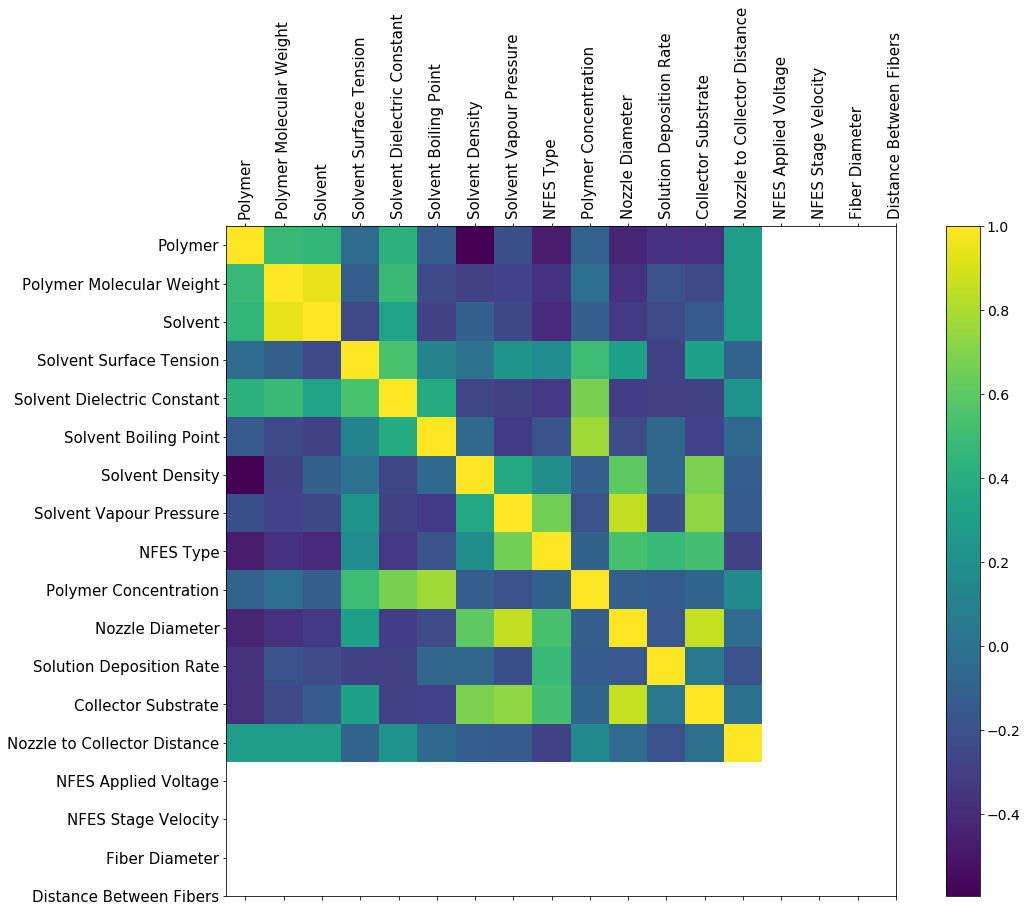

In [5]:
# all '-1's are to remove 'Reference' from the Correlation Matrix
scale = 6;
fig = plt.figure(figsize=(3*scale, 2*scale))
plt.matshow(df.iloc[:, :-1].corr(), fignum=fig.number)
plt.xticks(range(df.shape[1]-1), df.columns[:-1], rotation=90)
plt.yticks(range(df.shape[1]-1), df.columns[:-1], rotation=00)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [6]:
# Multivariate Linear Regression
df_x = df.sort_values(by=['Fiber Diameter'])
df_x = df_x.dropna(subset=['Polymer Concentration','Nozzle Diameter','NFES Applied Voltage','Fiber Diameter'])

# X is the independent variable (bivariate in this case)
X = np.array([df_x.iloc[:]['Polymer Concentration'], df_x.iloc[:]['Nozzle Diameter'], df_x.iloc[:]['NFES Applied Voltage']])

# Y is the dependent data
Y = df_x.iloc[:]['Fiber Diameter']

# predict is an independent variable for which we'd like to predict the value
predict= [[20.0, 750.0, 9000.0]]

# generate a model of polynomial features
poly = PolynomialFeatures(degree=2)

# transform the x data for proper fitting (for single variable type it returns,[1,x,x**2])
X_ = poly.fit_transform(X)

# transform the prediction to fit the model type
predict_ = poly.fit_transform(predict)

# generate the regression object
clf = LinearRegression()

# perform the actual regression
clf = clf.fit(np.transpose(X), Y)

print('\n')
print('>>> INTERCEPT & COEFFICIENTS')
print(clf.intercept_)
print(clf.coef_)
print('\n')
print('>>> PREDICTION')
print("Prediction = " + str(clf.predict(predict)))
print('\n')



>>> INTERCEPT & COEFFICIENTS
-4203.016618967483
[386.04599765   8.47750124   2.00228249]


>>> PREDICTION
Prediction = [27896.57166107]




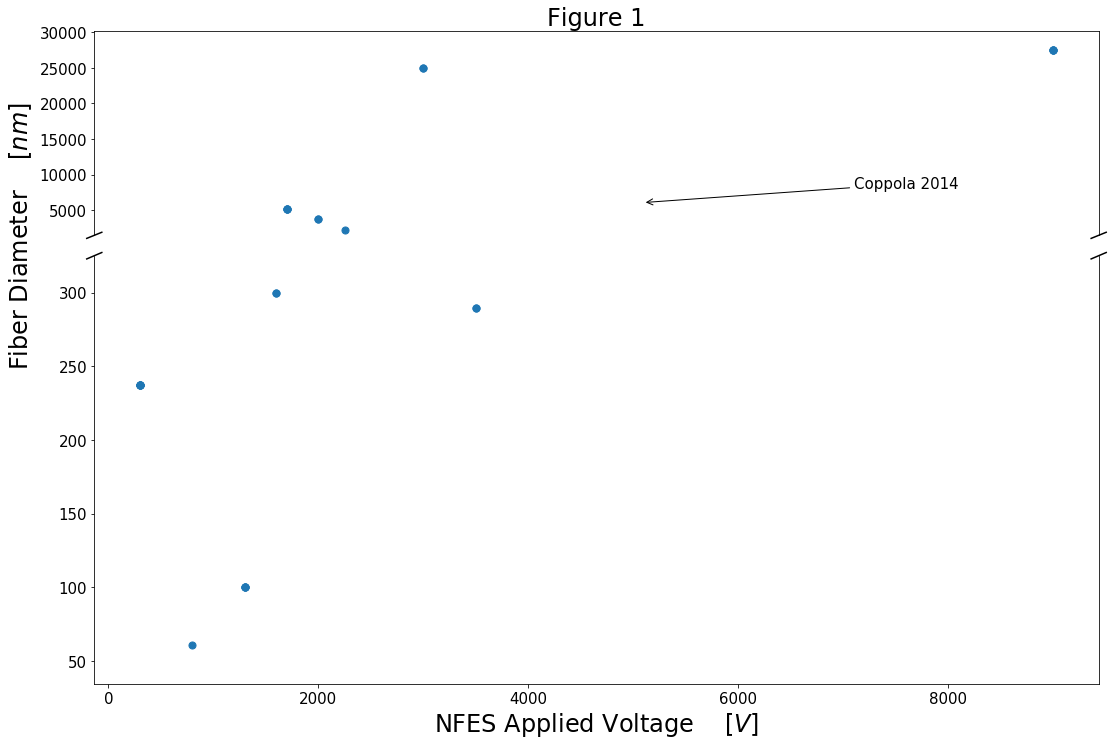

In [25]:
# PLOT FIG
fig_name = 'Figure 1';
x_str = 'NFES Applied Voltage'; x_units = r'$[V]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakLim = [325, 1500];

scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakLim);
#scatterPlot(x_str, x_units, y_str, y_units, df, 'original: ' + fig_name)

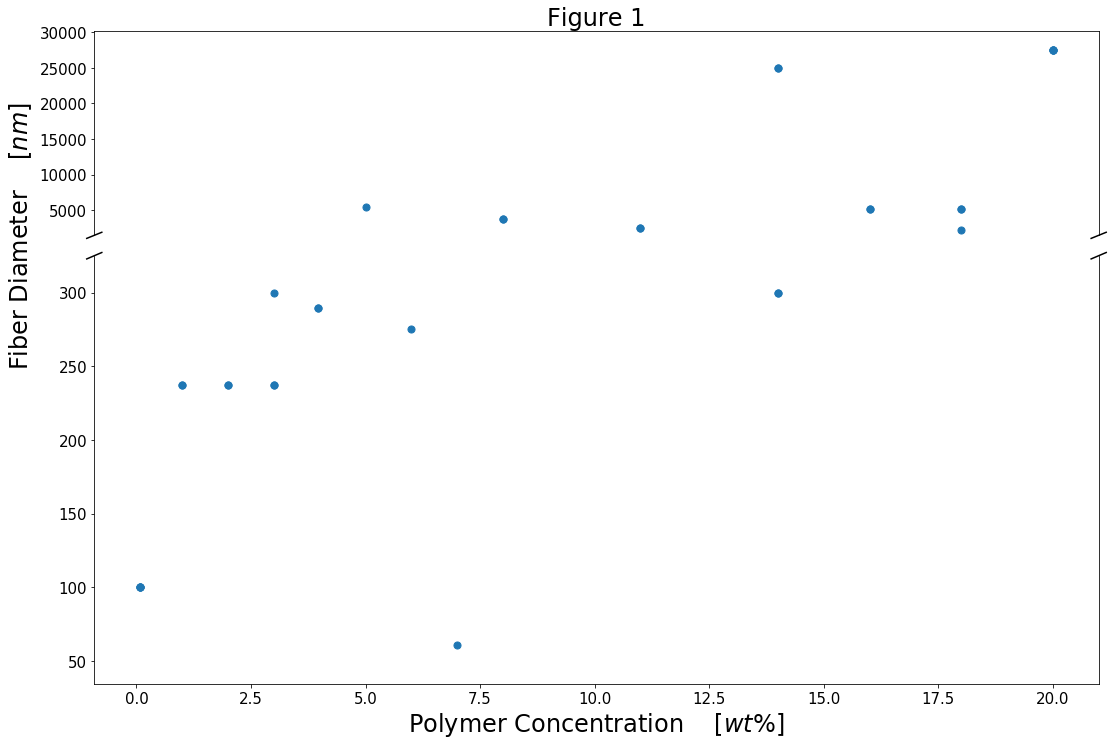

In [21]:
# PLOT FIG
fig_name = 'Figure 1';
x_str = 'Polymer Concentration'; x_units = r'$[wt\%]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakLim = [325, 1500];

scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, df_x, fig_name, breakLim);
#scatterPlot(x_str, x_units, y_str, y_units, df, 'original: ' + fig_name)

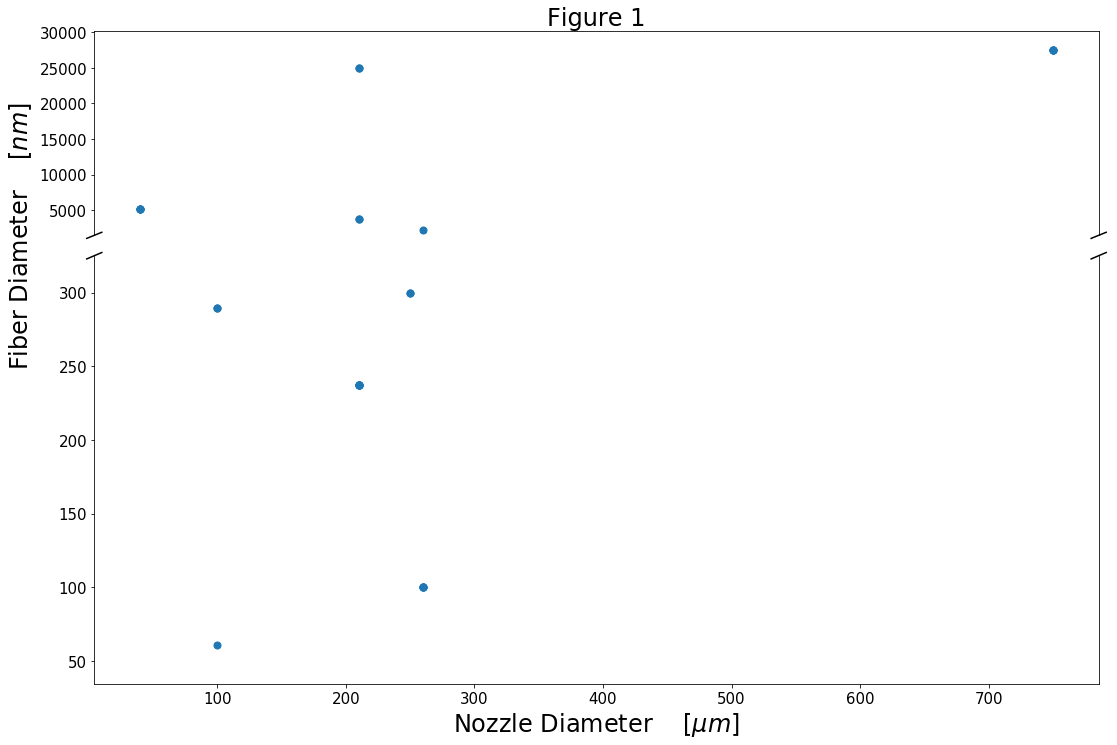

In [22]:
# PLOT FIG
fig_name = 'Figure 1';
x_str = 'Nozzle Diameter'; x_units = r'$[\mu m]$';
y_str = 'Fiber Diameter'; y_units = r'$[nm]$';
breakLim = [325, 1500];

scatterPlot_breakAxis(x_str, x_units, y_str, y_units, df, fig_name, breakLim);
#scatterPlot(x_str, x_units, y_str, y_units, df, 'original: ' + fig_name)